## Loading dataset

In [19]:
%%time
import pandas as pd
import xml.etree.ElementTree as ET

NONE_REPR = '__None__'                     # representation of none word - at the beginning and end of sentence

token_list = []
lemma_list = []
pos_list = []
is_negation_list = []


def add_nan():
    token_list.append(NONE_REPR)
    token_list.append(NONE_REPR)
    lemma_list.append(NONE_REPR)
    lemma_list.append(NONE_REPR)
    pos_list.append(NONE_REPR)
    pos_list.append(NONE_REPR)
    is_negation_list.append(0)
    is_negation_list.append(0)


root = ET.parse('korpus_scraper/dataset-ne.xml').getroot()

for sentence in root:
    add_nan()
    
    for token in sentence:
        token_list.append(token.text)
        lemma_list.append(token.attrib['lemma'])
        pos_list.append(token.attrib['pos'])
        is_negation_list.append(int('negator' in token.attrib))
    
    add_nan()

df_start = pd.DataFrame.from_dict({
    'token': token_list, 
    'lemma': lemma_list, 
    'POS': pos_list, 
    'is_negation': is_negation_list,
})

# Split dataset into train and test sets
split = 0.75
train = df_start[:int(split*len(df_start))]
test = df_start[int(split*len(df_start)):]
X_train = train[['token', 'lemma', 'POS']]
X_test = test[['token', 'lemma', 'POS']]
y_train = train.is_negation
y_test = test.is_negation

CPU times: user 13.5 ms, sys: 3.78 ms, total: 17.2 ms
Wall time: 17.2 ms


## Vectorizing

In [20]:
# Prepare sets for features
prefix_sk = {'ne', 'bez', 'pa', 'roz', 'proti', 'polo', 'tiež', 'akoby', 'trochu', 'truc', 'mimo', }
prefix_int = {'pseudo', 'i', 'in', 'anti', 'kontra', 'a', 'an', 'ex', 'non', 'kvázi', 'hypo', 'de', 'dez', 'ex', 
              'extra', }
particles = {'nie', 'figu', 'drevenú', 'figu', 'borovú', 'jalovú', 'figu', 'šušku', 'šušku', 'borovú', 'čerta', 'čerta', 
             'starého', 'čerta', 'rohatého', 'čerta', 'pekelného', 'čerta', 'ušatého', 'čerta', 'strapatého', 'paroma', 
             'paroma', 'starého', 'hroma', 'psiu', 'mater', 'horký', 'horkýtam', 'horkýže', 'horkýžetam', 'aleba', 
             'ale', 'čo', 'kde', 'kdeže', 'kdeby', 'kdežeby', 'kdežetam', 'kdežebytam', 'čo', 'čože', 'čoby', 'čožeby', 
             'ešte', 'čo', 'ešteže', 'čo', 'akurát', 'javeru', 'rozhodne', 'rovno', 'aký', 'akýže', 'akéže', }
slovak_dict = set(line.strip() for line in open('sk.dic'))


def start_with_prefix(word, prefixes):
    for p in prefixes:
        if word.startswith(p):
            return True, p
    return False, p


def detect_prefixes_and_particles(lemma):
    has_sk_prefix, p_sk = start_with_prefix(lemma, prefix_sk)
    has_int_prefix, p_int = start_with_prefix(lemma, prefix_int)
    is_particle = lemma in particles
    if has_sk_prefix:
        prefix = p_sk
    elif has_int_prefix:
        prefix = p_int
    else:
        prefix = ''
    word_without_prefix_exist = lemma[len(prefix):] in slovak_dict
    return has_sk_prefix, has_int_prefix, is_particle, word_without_prefix_exist

In [45]:
%%time
# import csv
import unicodecsv as csv
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer


def add_prefix(prefix, iterable):
    for item in iterable:
        yield prefix + "_" + item


# learn training data vocabulary, then use it to create a document-term matrix
vect_lemma = CountVectorizer()
vect_pos = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
vect_lemma.fit(X_train.lemma)
vect_pos.fit(X_train.POS)

# create list with the names of columns in dataframe
lemma_feat_names = list(vect_lemma.get_feature_names())
pos_feat_names = list(vect_pos.get_feature_names())
column_names = ['has_sk_prefix', 'has_int_prefix', 'is_particle', 'word_without_prefix_exist'] + \
               list(add_prefix('word1', lemma_feat_names)) + \
               list(add_prefix('word2', lemma_feat_names)) + \
               list(add_prefix('word3', lemma_feat_names)) + \
               list(add_prefix('word4', lemma_feat_names)) + \
               list(add_prefix('word5', lemma_feat_names)) + \
               list(add_prefix('word1', pos_feat_names)) + \
               list(add_prefix('word2', pos_feat_names)) + \
               list(add_prefix('word3', pos_feat_names)) + \
               list(add_prefix('word4', pos_feat_names)) + \
               list(add_prefix('word5', pos_feat_names))


def create_features_list(dataframe):
    feautures_list = []
    for index, row in dataframe.iterrows():
        if index >= dataframe.iloc[-4].name:
            break
        # Prefixes + Particles
        prefices_and_particles = np.array(detect_prefixes_and_particles(dataframe.loc[index+2]['lemma']))
        # LEMMA
        dtm_lemma1 = vect_lemma.transform([row['lemma']])
        dtm_lemma2 = vect_lemma.transform([dataframe.loc[index+1]['lemma']])
        dtm_lemma3 = vect_lemma.transform([dataframe.loc[index+2]['lemma']])
        dtm_lemma4 = vect_lemma.transform([dataframe.loc[index+3]['lemma']])
        dtm_lemma5 = vect_lemma.transform([dataframe.loc[index+4]['lemma']])
        # POS
        dtm_pos1 = vect_pos.transform([row['POS']])
        dtm_pos2 = vect_pos.transform([dataframe.loc[index+1]['POS']])
        dtm_pos3 = vect_pos.transform([dataframe.loc[index+2]['POS']])
        dtm_pos4 = vect_pos.transform([dataframe.loc[index+3]['POS']])
        dtm_pos5 = vect_pos.transform([dataframe.loc[index+4]['POS']])
        all_things = np.concatenate([
            prefices_and_particles,
            dtm_lemma1.toarray()[0],
            dtm_lemma2.toarray()[0],
            dtm_lemma3.toarray()[0],
            dtm_lemma4.toarray()[0],
            dtm_lemma5.toarray()[0],
            dtm_pos1.toarray()[0],
            dtm_pos2.toarray()[0],
            dtm_pos3.toarray()[0],
            dtm_pos4.toarray()[0],
            dtm_pos5.toarray()[0],
        ])
        feautures_list.append(all_things)
    return feautures_list


def save_to_csv(filename, header_row, feautures_list):
    with open(filename, 'wb') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_MINIMAL)
        wr.writerow(header_row)
        for row in feautures_list:
            wr.writerow(row)

CPU times: user 15.1 ms, sys: 1.79 ms, total: 16.9 ms
Wall time: 17.1 ms


In [46]:
%%time

# First we transform data into lists
X_train_features_list = create_features_list(X_train)
X_test_features_list = create_features_list(X_test)

CPU times: user 4.22 s, sys: 56.3 ms, total: 4.27 s
Wall time: 4.3 s


In [47]:
%%time

# Now we save our data to csv files
save_to_csv('train.csv', column_names, X_train_features_list)
save_to_csv('test.csv', column_names, X_test_features_list)

CPU times: user 5.53 s, sys: 46.6 ms, total: 5.57 s
Wall time: 5.62 s


## Training

In [48]:
%%time

# Load dataset
df_train = pd.DataFrame.from_csv('train.csv')
df_test = pd.DataFrame.from_csv('test.csv')

CPU times: user 915 ms, sys: 83.8 ms, total: 998 ms
Wall time: 1.17 s


In [49]:
%%time
# Import Library of Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB, MultinomialNB

# model = MultinomialNB()
model = GaussianNB()

# Train the model using the training sets 
model.fit(df_train, y_train[:-4])

CPU times: user 102 ms, sys: 42.4 ms, total: 144 ms
Wall time: 156 ms


## Metrics

In [50]:
from sklearn import metrics

y_pred_class = model.predict(df_test)

print('Accuracy: {}'.format(metrics.accuracy_score(y_test[:-4], y_pred_class)))
print('Precision: {}'.format(metrics.precision_score(y_test[:-4], y_pred_class)))
print('Recall: {}'.format(metrics.recall_score(y_test[:-4], y_pred_class)))
print('F1 score: {}'.format(metrics.f1_score(y_test[:-4], y_pred_class)))

Accuracy: 0.9288025889967637
Precision: 0.26666666666666666
Recall: 0.26666666666666666
F1 score: 0.26666666666666666


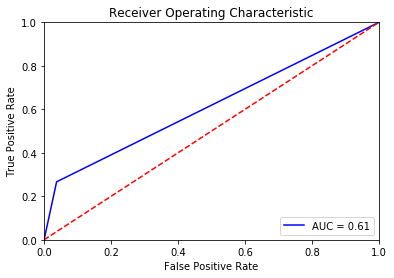

In [51]:
import matplotlib.pyplot as plt

fpr, tpr, threshold = metrics.roc_curve(y_test[:-4], y_pred_class)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Playground

In [53]:
y_train[5]
new[5]

array([0, 0, 0, ..., 0, 0, 0])

In [56]:
#Predict Output 
predicted = model.predict([new[2]])
print(predicted)

[0]


In [87]:
from itertools import chain
from timeit import timeit


def bla1():
    c = chain(
        add_prefix("word1", lemma_feat_names), 
        add_prefix("word2", lemma_feat_names), 
        add_prefix("word3", lemma_feat_names), 
        add_prefix("word4", lemma_feat_names),
        add_prefix("word5", lemma_feat_names),
    )
    return list(c)


def bla2():
    return list(add_prefix("word1", lemma_feat_names)) + \
           list(add_prefix("word2", lemma_feat_names)) + \
           list(add_prefix("word3", lemma_feat_names)) + \
           list(add_prefix("word4", lemma_feat_names)) + \
           list(add_prefix("word5", lemma_feat_names))


print(timeit('bla1()', globals=globals(), number=1000))
print(timeit('bla2()', globals=globals(), number=1000))

6.6219878520059865


6.410430869989796
